In [19]:
import random
import numpy as np
from scipy.stats.stats import spearmanr
import matplotlib.pyplot as plt
import pickle as pkl

# Create Data

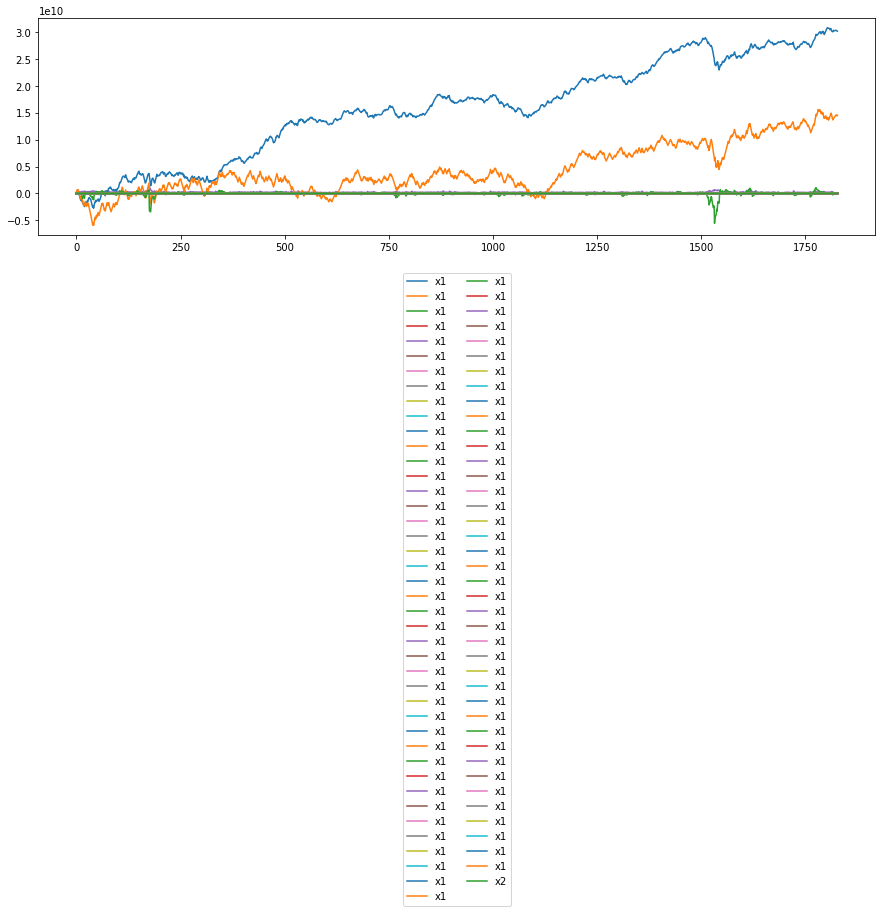

In [20]:
# pattern + trend + noise

x1 = np.load('xdata.npy')
x2 = np.load('ydata.npy')

t = np.linspace(0, len(x1), len(x1))

plt.figure(figsize=(15, 4))
plt.plot(range(len(x1)), x1, label='x1')
plt.plot(range(len(x2)), x2, label='x2')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [21]:
print(x1.shape)
print(x2.shape)
len(x1)

(1828, 82)
(1828, 1)


1828

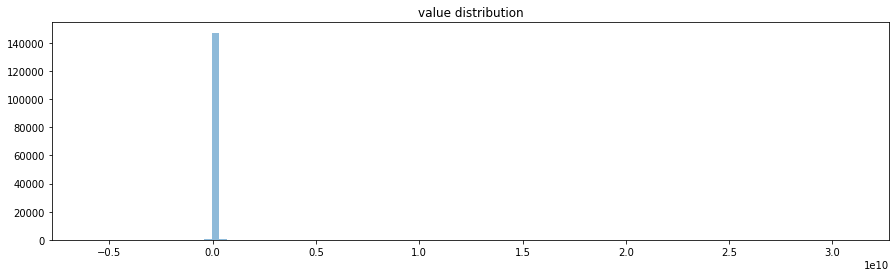

In [22]:
plt.figure(figsize=(15, 4))
plt.hist(np.column_stack([x1, x2]).flatten(), bins=100, alpha=0.5)
plt.title('value distribution')
plt.show()

# Prepare Data

### Split

In [23]:
train_ratio = .8
train_len = int(train_ratio*t.shape[0])
print(train_len)

1462


### Combine

In [24]:
# x_lbl columns: ===================
# columns1: detrended x1, 
# columns2: detrended x2, 
# columns3: index
# columns4: 1 for train set, 0 for test set
x1_detrend = x1
x2_detrend = x2
x_index = np.array(range(len(t)))
x_lbl = np.column_stack([x1_detrend, x2_detrend, x_index, [1]*train_len+[0]*(len(x_index)-train_len)])
print(x_lbl.shape)
print(x_lbl)

(1828, 85)
[[3.71934932e+02 3.70034896e+02 3.68004671e+02 ... 5.09000000e-02
  0.00000000e+00 1.00000000e+00]
 [3.71934932e+02 3.70034896e+02 3.68004671e+02 ... 6.25857143e-02
  1.00000000e+00 1.00000000e+00]
 [3.71934932e+02 3.70034896e+02 3.68004671e+02 ... 7.42714286e-02
  2.00000000e+00 1.00000000e+00]
 ...
 [4.02750000e+02 4.00250000e+02 4.00190000e+02 ... 4.64857143e-02
  1.82500000e+03 0.00000000e+00]
 [4.00230000e+02 3.99030000e+02 3.98500000e+02 ... 4.17428571e-02
  1.82600000e+03 0.00000000e+00]
 [4.00230000e+02 3.99030000e+02 3.98500000e+02 ... 3.70000000e-02
  1.82700000e+03 0.00000000e+00]]


### Normalize

In [25]:
x_lbl[x_lbl[:, -1]==1].shape

(1462, 85)

In [26]:
x_train_max = x_lbl[x_lbl[:, -1]==1].max(axis=0)
x_train_max.shape
#x_train_max

(85,)

In [27]:
#x_train_max = x_train_max.tolist()+[1]*2  # only normalize for the first 2 columns
x_train_max[-2:] = 1
print(x_train_max[-2:])

[1. 1.]


In [28]:
# x_lbl columns: ===================
# columns1: normalized detrended x1, 
# columns2: normalized detrended x2, 
# columns3: index
# columns4: 1 for train set, 0 for test set

x_normalize = np.divide(x_lbl, x_train_max)
print(x_normalize)

[[8.84043857e-01 8.81581207e-01 8.78460497e-01 ... 3.01540284e-01
  0.00000000e+00 1.00000000e+00]
 [8.84043857e-01 8.81581207e-01 8.78460497e-01 ... 3.70768450e-01
  1.00000000e+00 1.00000000e+00]
 [8.84043857e-01 8.81581207e-01 8.78460497e-01 ... 4.39996615e-01
  2.00000000e+00 1.00000000e+00]
 ...
 [9.57287507e-01 9.53566494e-01 9.55289793e-01 ... 2.75389303e-01
  1.82500000e+03 0.00000000e+00]
 [9.51297775e-01 9.50659932e-01 9.51255610e-01 ... 2.47291808e-01
  1.82600000e+03 0.00000000e+00]
 [9.51297775e-01 9.50659932e-01 9.51255610e-01 ... 2.19194313e-01
  1.82700000e+03 0.00000000e+00]]


/home/skycam/venv3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


In [29]:
x_normalize.shape

(1828, 85)

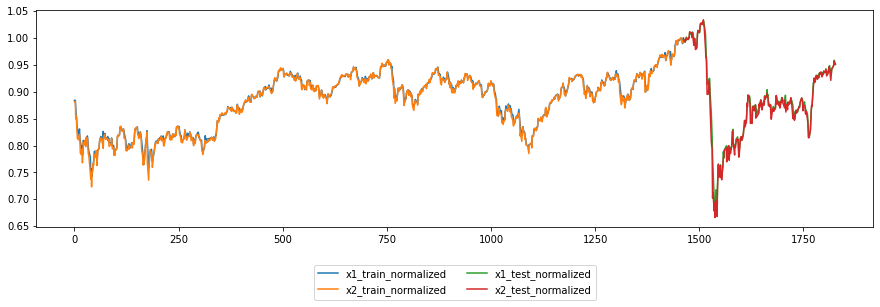

In [30]:
plt.figure(figsize=(15, 4))
plt.plot(range(train_len), x_normalize[:train_len, 0], label='x1_train_normalized')
plt.plot(range(train_len), x_normalize[:train_len, 1], label='x2_train_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 0], label='x1_test_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 1], label='x2_test_normalized')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

### Truncate

In [31]:
def truncate(x, feature_cols=range(x_normalize.shape[1]), target_cols=82, label_col=x_normalize.shape[1]-1, train_len=100, test_len=20):
    in_, out_, lbl = [], [], []
    for i in range(len(x)-train_len-test_len+1):
        in_.append(x[i:(i+train_len), feature_cols].tolist())
        out_.append(x[(i+train_len):(i+train_len+test_len), target_cols].tolist())
        lbl.append(x[i+train_len, label_col])
    return np.array(in_), np.array(out_), np.array(lbl)
    

In [33]:
X_in, X_out, lbl = truncate(x_normalize)
print(X_in.shape, X_out.shape, lbl.shape)

(1709, 100, 85) (1709, 20) (1709,)


In [34]:
X_input_train = X_in[np.where(lbl==1)]
X_output_train = X_out[np.where(lbl==1)]

X_input_test = X_in[np.where(lbl==0)]
X_output_test = X_out[np.where(lbl==0)]

print(X_input_train.shape, X_output_train.shape)
print(X_input_test.shape, X_output_test.shape)

(1362, 100, 85) (1362, 20)
(347, 100, 85) (347, 20)


In [37]:
pkl.dump({'X_input_train': X_input_train, 
          'X_output_train': X_output_train, 
          'X_input_test': X_input_test, 
          'X_output_test': X_output_test, 
          'x_train_max': x_train_max
         }, open('data.pkl', 'wb'))

In [38]:
print('X_input_train', X_input_train.shape, 
          'X_output_train', X_output_train.shape, 
          'X_input_test', X_input_test.shape, 
          'X_output_test', X_output_test.shape, 
          'x_train_max', x_train_max.shape)

X_input_train (1362, 100, 85) X_output_train (1362, 20) X_input_test (347, 100, 85) X_output_test (347, 20) x_train_max (85,)
